In [33]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 20 09:42:10 2020

@author: rhoover
"""

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import community
from networkx.generators.community import LFR_benchmark_graph

##  Tensor packages for Tucker, etc.  ###
from sktensor.tucker import hooi
from sktensor import dtensor

### Standard Linear Algebra Package  ###
from scipy import linalg

In [34]:
plt.close()

N = 20 # Time steps
n = 40 # Nodes
p = 0.4

adj = np.zeros([n,n,2*N+2])

In [35]:
# Create random graph and store to the last lateral slice of adj
G = nx.fast_gnp_random_graph(n,p,seed = 4652, directed = False)
G_adj = nx.to_numpy_matrix(G)
adj[0:n,0:n,0] = G_adj # Stoer the first adjacency matrix in the first frontal slice of adj

In [36]:
# Create another random graph and store to the last lateral slice of adj
#G = nx.fast_gnp_random_graph(n,p,seed = 4652, directed = False)
#G_adj = nx.to_numpy_matrix(G)
adj[0:n,0:n,(2*N+2) - 1] = G_adj # Store the last adjacency matrix in the last frontal slice of adj

In [37]:
#  Generate graph community over 20 graphs.
for i in range(1,N+1):
    q = p-p*i/(N+1)
    P = np.array([[p,q],[q,p]])
    Gsbm = nx.to_numpy_matrix(nx.stochastic_block_model([int(n/2),int(n/2)],P))
    adj[0:n,0:n,i] = Gsbm
    #print(i)

In [38]:
###  Generate back end (from communities to single community) - and plot in the loop
eps = 0.0
print('The j vector')
for j in range(1,N+2):
    q = p*(j-1)/(N+2) + eps#remove the eps for complete dissconnectivity #
    P = np.array([[p,q],[q,p]])
    Gsbm = nx.to_numpy_matrix(nx.stochastic_block_model([int(n/2),int(n/2)],P))
    adj[0:n,0:n,i+j] = Gsbm
    #print(i+j)

The j vector


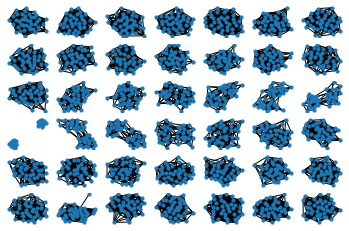

In [39]:
####  Visualization of the graphs
plt.figure(1)
for i in range(2*N+2):
    plt.subplot(6,7,i+1)
    nx.draw(nx.from_numpy_matrix(adj[0:n,0:n,i]),node_size = 10)

In [50]:
#### Generate ind matrix
ind = np.zeros(adj.shape)

for t in range (2*N+2):
    for node in range(n):
        ind[node, node, t] = sum(adj[node, :, t])
        

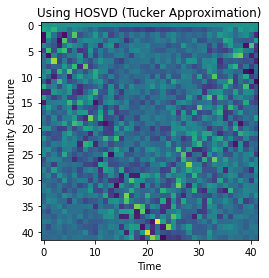

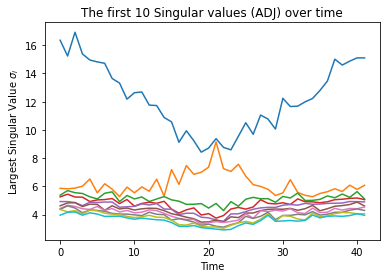

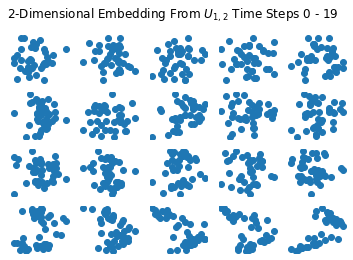

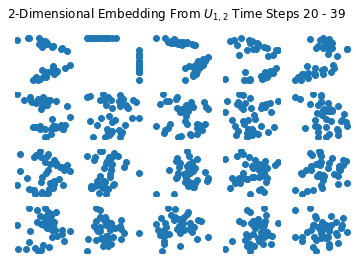

In [43]:
####  Decompose using the Tucker decomposition  ####
T = dtensor(adj)
Y = hooi(T, [n, n, 2*N+2], init='nvecs')

U1 = Y[1][0]
U2 = Y[1][1]
U3 = Y[1][2]

plt.figure(2)

plt.imshow(U3.T)
plt.xlabel('Time')
plt.ylabel('Community Structure')
plt.title('Using HOSVD (Tucker Approximation)')

s_vec = np.zeros([10, 2*N+2])
U_data = np.zeros([n,n,2*N+2])
V_data = np.zeros([n,n,2*N+2])
for i in range(2*N+2):
    U, s, Vh = np.linalg.svd(adj[0:n,0:n,i],full_matrices = True, compute_uv = True)
    for j in range(0, 10):
        s_vec[j,i] = s[j]
    U_data[0:n,0:n,i] = U
    V_data[0:n,0:n,i] = Vh

plt.figure(3)
for j in range(0, 10):
    plt.plot(s_vec[j, :])
plt.xlabel('Time')
plt.ylabel('Largest Singular Value $\sigma_i$')
plt.title('The first 10 Singular values (ADJ) over time')

#####################

plt.figure(4)
for i in range(N):
    plt.subplot(4,5,i+1)
    plt.scatter(U_data[0:n,0:1,i],U_data[0:n,1:2,i])

    plt.axis('off')
plt.suptitle('2-Dimensional Embedding From $U_{1,2}$ Time Steps 0 - 19')

plt.figure(5)
plt_cnt = 1
for i in range(N,2*N):
    plt.subplot(4,5,plt_cnt)
    plt.scatter(U_data[0:n,0:1,i],U_data[0:n,1:2,i])
    plt_cnt +=1
    plt.axis('off')
plt.suptitle('2-Dimensional Embedding From $U_{1,2}$ Time Steps 20 - 39')
plt.show()